In [1]:
import models.models_one_task as md_one
import datasets.datasets as ds
from constants import *
from torchsummary import summary
import torch
import torch.nn as nn
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.classifier import NeuralNetClassifier
import skorch.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt

# Описание и демонстрация модулей

# Модуль models_one_task 

Модуль models_one_task на данный момент содержит PyTorch имплементацию следующих моделей для однозадачного обучения:

## AlexNet

[Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. <i>Commun. ACM</i> 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386]

Архитектура немного переделана, чтобы соответствовать нашей специфике:<br>
1. Количество входных каналов первого сверточного слоя уменьшено с 3 до 1
2. Изменён последний свёрточный слой, его ядро увеличено с (3, 3) до (4, 4)
3. Изменён слой AdaptiveAvgPool2d с (6, 6) до (5, 5)
4. Изменён классификатор, теперь это четыре полносвязных слоя: 6400, 2048, 512, <число классов>
5. Добавлен Dropout() после первого и второго полносвязного слоя

In [2]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=256)
model=None
torch.cuda.empty_cache()

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
 

## VGG

[Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. ]

Архитектура классификатора переделана в схожей с AlexNet манере.

In [3]:
# type - тип модели (11, 16, 19)
# bn - batch norm
model = md_one.vgg(num_classes=4, type=11, bn=False)
model = model.to(device)
print(model)
summary(model, (1, 224, 224), batch_size=64)
model=None
torch.cuda.empty_cache()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## SER DeepNet

[Anvarjon, T.; Mustaqeem; Kwon, S. Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features. Sensors 2020, 20, 5212.]

У этой архитектуры заявлена точность на четырехклассовом IEMOCAP 77%. Отличается использованием свёртки с ядрами от (11,1) до (1,1), таким образом, свёртка спектрограммы происходит только по частотной оси. <br>
На вход подаются спектрограммы размерности 64х64

In [4]:
model = md_one.PaperCnnDeepNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 64, 64), batch_size=64)

PaperCnnDeepNet(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
    (1): ReLU(inplace=True)
    (2): Conv2d(10, 10, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
    (3): ReLU(inplace=True)
    (4): Conv2d(10, 10, kernel_size=(3, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(10, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (9): ReLU(inplace=True)
    (10): Conv2d(20, 20, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Conv2d(20, 40, kernel_size=(13, 1), stride=(1, 1), padding=(6, 0))
    (15): Re

## SER StrideNet

[., Mustaqeem & Kwon, Soonil. (2019). A CNN-Assisted Enhanced Audio Signal Processing for Speech Emotion Recognition. Sensors. 20. 183. 10.3390/s20010183. ]

Ещё одна архитектура с высокой заявленной точностью.
Особенностью этой архитектуры является отсутствие Pooling слоёв: снижение размерности достигается использованием шага свёртки, равного двум. <br>
На вход подаются спектрограммы размером 128x128

In [14]:
model = md_one.PaperCnnStrideNet(num_classes=4)
model = model.to(device)
print(model)
summary(model, (1, 128, 128), batch_size=64)

PaperCnnStrideNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (11): ReLU(inplace=True)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (13): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=True)
    (3): Linear(in_features=512, out_features=4, bias=True)
  )
)


# Модуль datasets

Данный модуль содержит классы IemocapDataset и RamasDataset - датасеты для нашей задачи. <br>
При инициализации экземпляра класса, производится попытка считать файл нужного исходя из указанных параметров датасета. 
Если попытка неудачна, будет начат процесс по составлению такого файла. За всеми подробностями добро пожаловать в 
datasets/datasets.py

## Датасет IEMOCAP

In [12]:
iemocap = ds.IemocapDataset(
    """
    Пути до файлов
    """
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    """    
    Параметры, по которым будет искаться .pkl-файл датасета. Изменение этих параметров у уже инициализированного экземпляра
    либо не приведет ни к какому результату, либо сломает программу, поэтому если их нужно поменять, то лучше инициализировать
    новый экземпляр
    
    base_name - идентификационное имя
    
    label_type - тип используемой разметки для IEMOCAP: 'four' - четыре класса (ang, hap, neu, sad), 'original' - все классы.
    mode - тренировочный или тестовый набор. Было заранее проведено разделение wav файлов на тренировочный и тестовый наборы
    (см. datasets/train_test_splits.py) c одинаковой взвешенностью эмоциональных классов.
    
    preprocessing - использовать или нет препроцессинг (удаление шума и тишины)
    """
    base_name='IEMOCAP', label_type='four', mode='train', preprocessing=False, 
    """    
    Параметры, влияющие на тип получаемых при индексации данных.
    Эти параметры можно менять у уже инициализированных экземпляров.
    
    augmentation - аугментация тренировочных данных. 
    Если спектрограмма слишком короткая, и augmentation=True, то она подается на функцию аугментации.
    Функция аугментации эту спектрограмму случайным образом может либо дополнить самой собой случайное количество раз 
    (чего может быть недостаточно, поэтому функция организована рекурсивно) либо окружить нулями. Процесс продолжается 
    до тех пор, пока спектрограмма не станет либо нужного размера, либо большего. Спектрограммы большего размера 
    случайно обрезаются. Важно заметить, что аугментации подвергаются только лишь тренировочные данные, тестовые же 
    спектрограммы, если они слишком короткие, обрабатываются одинаково (с фиксированным случайным зерном) в зависимости 
    от значения параметра padding.
    
    padding - обработка слишком коротких спектрограмм.
    Подобным образом обрабатываются все тестовые экземпляры (с фиксированным зерном), а также можно таким образом обработать
    и тренировочные экземпляры (с не фиксированным зерном). Возможные варианты: 'zero' - окружить нулями до нужного размера, 
    'repeat' - повторить саму себя столько раз, сколько необходимо для достижения нужного или большего размера, затем обрезать.
    
    spectrogram_shape - размер спектрограммы. Может быть каким угодно целым, но используются 64, 128, 224 и 256.
    
    spectrogram_type - тип спектрограммы. Может быть 'spec' - обычная, и 'melspec' - мел-спектрограмма.
    
    tasks - список задач. Доступны: emotion, speaker, gender, valence, arousal, dominance для IEMOCAP; 
    emotion, speaker, gender для RAMAS.
    """
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)

SyntaxError: invalid syntax (<ipython-input-12-924d8a06020c>, line 5)

### Заранее готовы следующие варианты датасета IEMOCAP:

Четыре эмоциональные категории, с препроцессингом и без, тренировочный и тестовый наборы

In [3]:
iemocap_four_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_four_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_four_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_four_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_test ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_test ===============
=========================== SUCCESS! ====================================


Все эмоциональные категории, с препроцессингом и без, тренировочный и тестовый наборы

In [4]:
iemocap_original_noprep_train = ds.IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP', label_type='original', mode='train', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_original_noprep_test = ds.IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP', label_type='original', mode='test', preprocessing=False, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_original_prep_train = ds.IemocapDataset(  # C препроцессингом, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP', label_type='original', mode='train', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)
iemocap_original_prep_test = ds.IemocapDataset(  # С препроцессингом, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP', label_type='original', mode='test', preprocessing=True, 
    augmentation=False, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks=['emotion'] 
)

============= INITIALIZING DATASET IEMOCAP_original_prep-false_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP_original_prep-false_test ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP_original_prep-true_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP_original_prep-true_test ===============
=========================== SUCCESS! ====================================


### Метод show_image() позволяет взглянуть, какие спектрограммы выдает датасет в текущей конфигурации. 
#### Возвращает ax - объект Axes. Продемонстрирую с его помощью, как работает аугментация данных на примере тренировочного набора без препроцессинга с четырьмя категориями. Будет выведена четыре раза одна спектрограмма.

In [5]:
img, label = iemocap_four_noprep_train[0]
print(img.shape)

torch.Size([1, 224, 224])


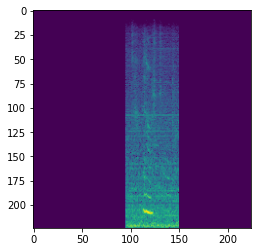

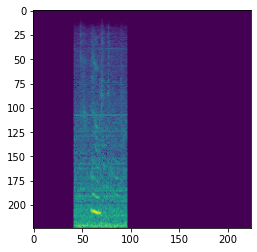

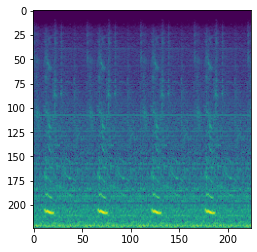

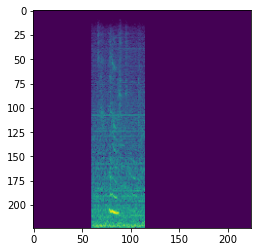

In [7]:
iemocap_four_noprep_train.augmentation = True
np.random.seed()
n = np.random.randint(1, len(iemocap_four_noprep_train))
for i in np.arange(1, 5):
        ax = iemocap_four_noprep_train.show_image(n)
        plt.show()

#### Тестовые спектрограммы ведут себя иначе, они всегда одинаковы
#### Однако, заранее нужно указать для всех будущих спектрограмм тип пэддигна, это небольшой минус

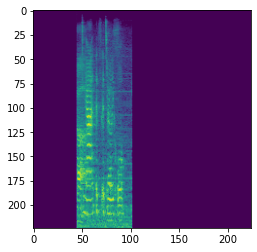

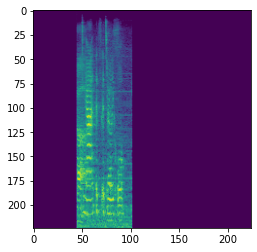

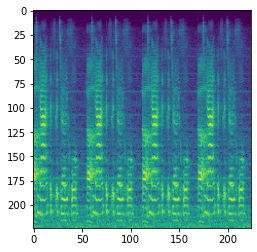

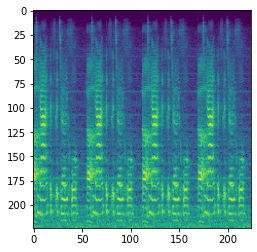

In [8]:
iemocap_four_noprep_test.padding = 'zero'  
np.random.seed()
n = np.random.randint(1, len(iemocap_four_noprep_test))
for i in np.arange(1, 3):
        ax = iemocap_four_noprep_test.show_image(n)
        plt.show()
iemocap_four_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_four_noprep_test.show_image(n)
        plt.show()

#### Также взглянем на результат препроцессинга

561


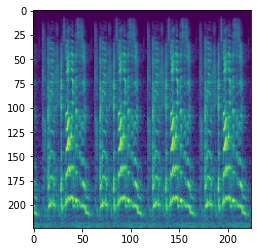

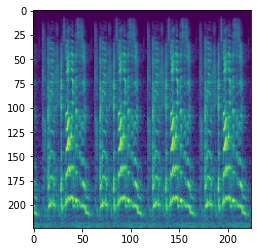

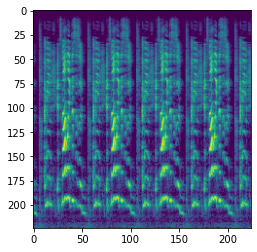

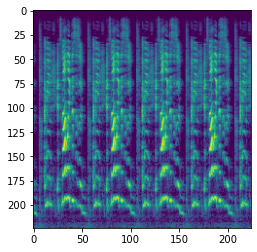

In [9]:
np.random.seed()
n = np.random.randint(1, len(iemocap_four_prep_test))
print(n)
iemocap_four_prep_test.padding = 'repeat'
iemocap_four_noprep_test.padding = 'repeat'
for i in np.arange(1, 3):
        ax = iemocap_four_noprep_test.show_image(n)
        plt.show()
for i in np.arange(1, 3):
        ax = iemocap_four_prep_test.show_image(n)
        plt.show()

# It's learning time!

## 1. Однозадачное обучение

### 1.1. Без препроцессинга и аугментации

#### AlexNet

In [10]:
train_dataset = iemocap_four_noprep_train
test_dataset = iemocap_four_noprep_test
train_dataset.augmentation = False
test_dataset.augmentation = False
test_dataset.padding = 'repeat'

In [11]:
X_test = [X for X, y in iter(test_dataset)]
y_test = [y for X, y in iter(test_dataset)]

In [13]:
model = md_one.alexnet(num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=64, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callbacks.EpochScoring(scoring="accuracy", lower_is_better=True, 
                               on_train=True, name='Train score', 
                               ),
    ]
)

In [14]:
net.fit(train_dataset, y=None)

  epoch    Train score    train_loss    valid_acc    valid_loss      dur
-------  -------------  ------------  -----------  ------------  -------
      1         0.3544        1.3876       0.3807        1.3121  65.1667
      2         0.4351        1.2400       0.5510        1.0639  63.5482


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

In [3]:
X_train = [X, for X, y in iter(iemocap_train)]
y_train = [y for X, y in iter(iemocap_train)]
X_test = [X for X, y in iter(iemocap_test)]
y_test = [y for X, y in iter(iemocap_test)]

In [4]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test)

In [5]:
train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_test, y_test)

(893, 1, 224, 224) (893,)


In [6]:
model = md_one.vgg(type=11, bn=False, num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=0.001, max_epochs=100, batch_size=64, train_split=predefined_split(valid_ds), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callbacks.EpochScoring(scoring="accuracy", lower_is_better=True, 
                               on_train=True, name='Train score', 
                               ),
#         callbacks.EpochScoring(scoring="accuracy", lower_is_better=True, 
#                                on_train=False, name='Test score'
#                               )
    ]
)

In [7]:
net.fit(train_ds, y=None)
torch.cuda.empty_cache()

  epoch    Train score    train_loss    valid_acc    valid_loss      dur
-------  -------------  ------------  -----------  ------------  -------
      1         0.3429        9.7939       0.3807        1.3251  18.4821
      2         0.3849        1.3376       0.4826        1.3133  18.4001
      3         0.4171        1.3205       0.3807        1.3027  18.4285
      4         0.4471        1.2128       0.4580        1.1446  18.4811
      5         0.5221        1.1058       0.5834        1.0180  18.4677
      6         0.5602        1.0630       0.6092        0.9748  18.4613
      7         0.5633        1.0383       0.5442        1.0376  18.4642
      8         0.5733        1.0234       0.6170        0.9643  18.5193
      9         0.5829        1.0054       0.6237        0.9321  18.5052
     10         0.5882        0.9802       0.6271        0.9384  18.5809
     11         0.6047        0.9564       0.5890        0.9929  18.5058
     12         0.6201        0.9231       0.6047  